In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/road-sign-detection
!unzip /content/road-sign-detection.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 99% 216M/218M [00:12<00:00, 18.0MB/s]
100% 218M/218M [00:12<00:00, 18.7MB/s]
Archive:  /content/road-sign-detection.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflat

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
cd yolov5

/content/yolov5


In [4]:
!pip install -r requirements.txt

In [5]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

In [6]:
input_path = '/content/'
output_path = '/content/yolov5'


In [7]:
annotations_path = os.path.join(input_path, 'annotations')
annotations = os.listdir(annotations_path)

In [8]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:00<00:00, 17209.64it/s]


In [9]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

img_name width height xmin ymin xmax ymax         label
0  road249.png   300    400  145  239  156  251    speedlimit
1  road653.png   300    400  161  219  181  240    speedlimit
2  road653.png   300    400   93  230  108  246    speedlimit
3  road653.png   300    400  117  211  136  229     crosswalk
4   road38.png   400    267   31    0   83  102  trafficlight

In [10]:
!pip install pybboxes

In [11]:
import numpy as np
import pandas as pd
import os
import pybboxes as pbx
from collections import defaultdict
from tqdm import tqdm
import shutil

In [12]:
classes = labels_df['label'].unique().tolist()
classes

['speedlimit', 'crosswalk', 'trafficlight', 'stop']

In [13]:
## Add class number associated to classes
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

img_name width height xmin ymin xmax ymax         label  class
0  road249.png   300    400  145  239  156  251    speedlimit      0
1  road653.png   300    400  161  219  181  240    speedlimit      0
2  road653.png   300    400   93  230  108  246    speedlimit      0
3  road653.png   300    400  117  211  136  229     crosswalk      1
4   road38.png   400    267   31    0   83  102  trafficlight      2

In [14]:
## Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

100%|██████████| 1244/1244 [00:00<00:00, 1672.88it/s]


In [15]:
# make labels dir in data folder of yolov5
labels_dir = f'{output_path}/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [16]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [17]:
import os
import shutil
from random import shuffle

In [18]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [19]:
# create train , val folders in data directory of yolov5
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [20]:
# Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [21]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [22]:
images_path, labels_path, train_dir

('/content//images',
 '/content/yolov5/data/labels',
 '/content/yolov5/data/train')

In [23]:
# Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [24]:
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

In [25]:
with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

In [26]:
epochs = 30
!python train.py --img 640 --batch 32 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

2024-05-04 05:09:28.359114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 05:09:28.359169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 05:09:28.431569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, 

In [27]:
# results stored in runs/train
# get the last stored result
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp
print(exp)

exp


In [28]:
os.listdir(exp_path)

['R_curve.png',
 'hyp.yaml',
 'labels_correlogram.jpg',
 'results.png',
 'events.out.tfevents.1714799371.9f892a84ba97.1752.0',
 'confusion_matrix.png',
 'val_batch0_labels.jpg',
 'PR_curve.png',
 'P_curve.png',
 'opt.yaml',
 'train_batch1.jpg',
 'F1_curve.png',
 'weights',
 'val_batch1_labels.jpg',
 'val_batch1_pred.jpg',
 'labels.jpg',
 'train_batch2.jpg',
 'val_batch0_pred.jpg',
 'train_batch0.jpg',
 'results.csv',
 'val_batch2_labels.jpg',
 'val_batch2_pred.jpg']

In [29]:
import matplotlib.pyplot as plt
from PIL import Image

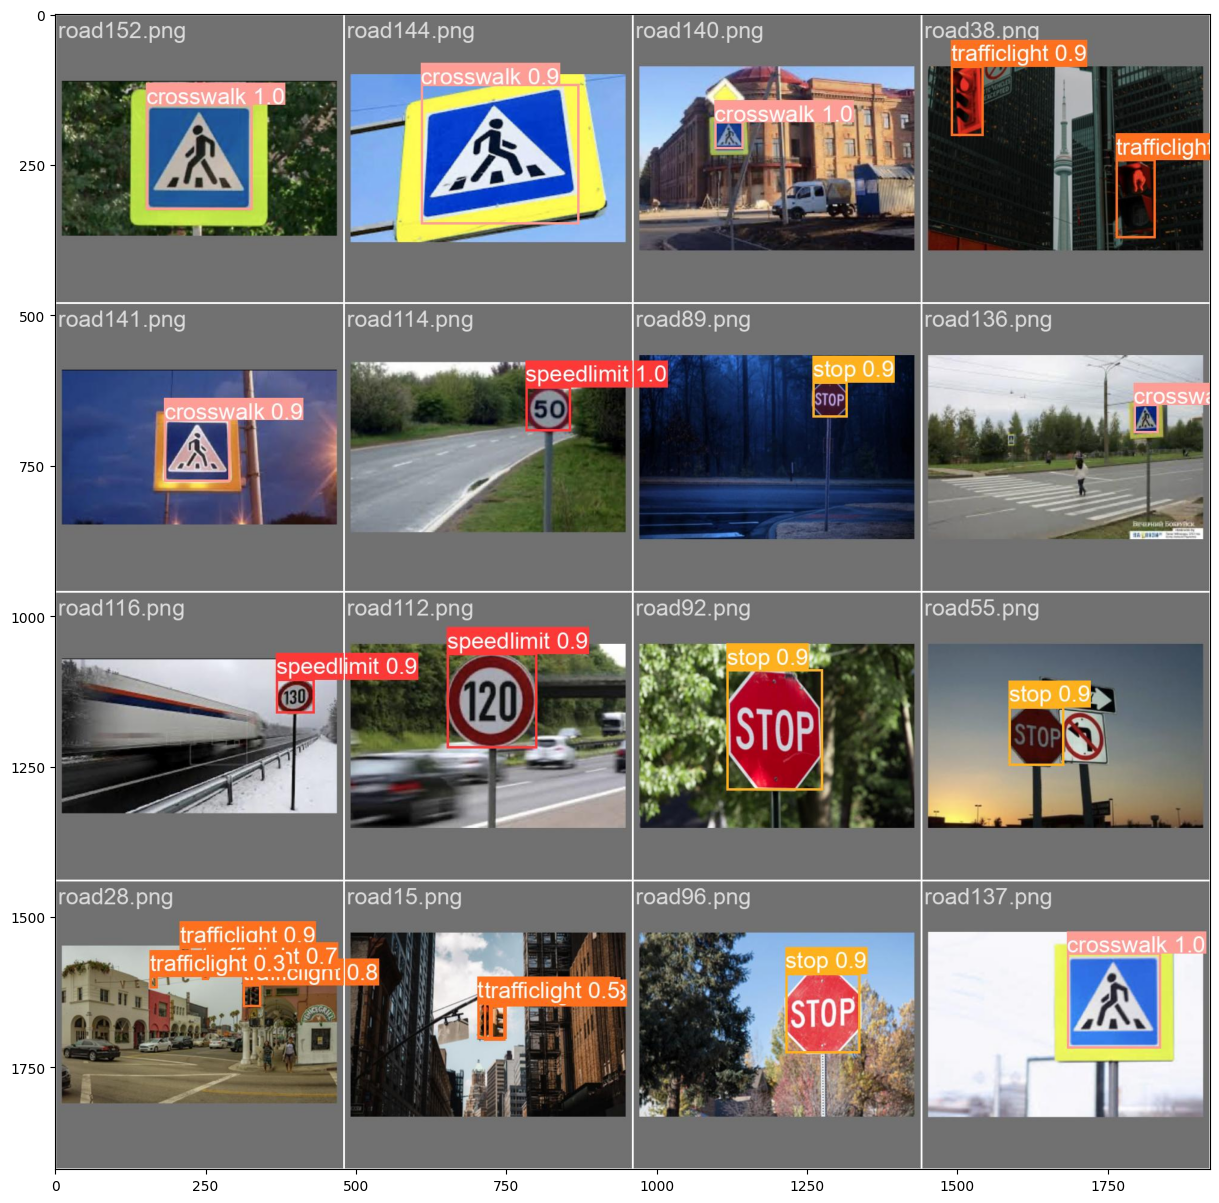

In [30]:
img_path = '/content/yolov5/runs/train/exp/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)

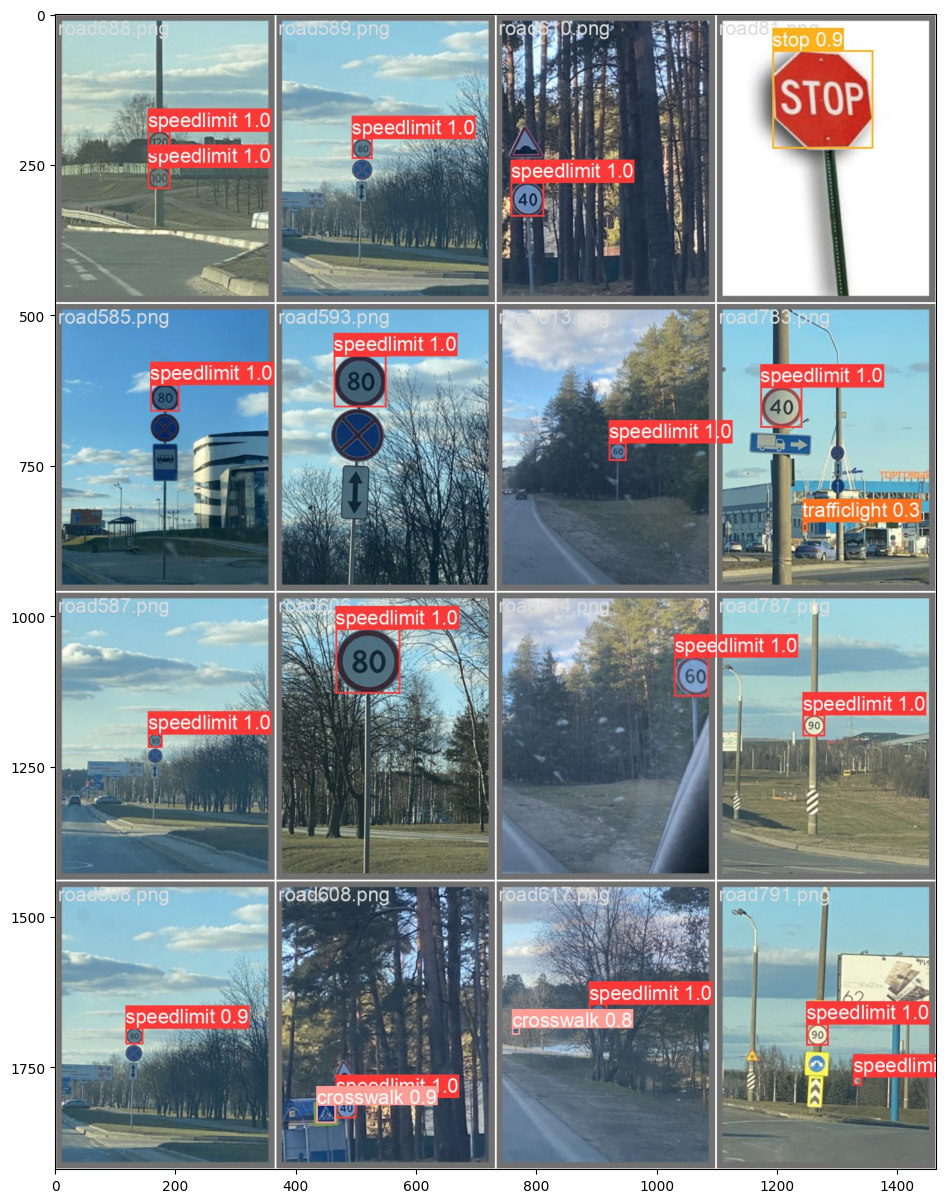

In [31]:
img_path = '/content/yolov5/runs/train/exp/val_batch1_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)

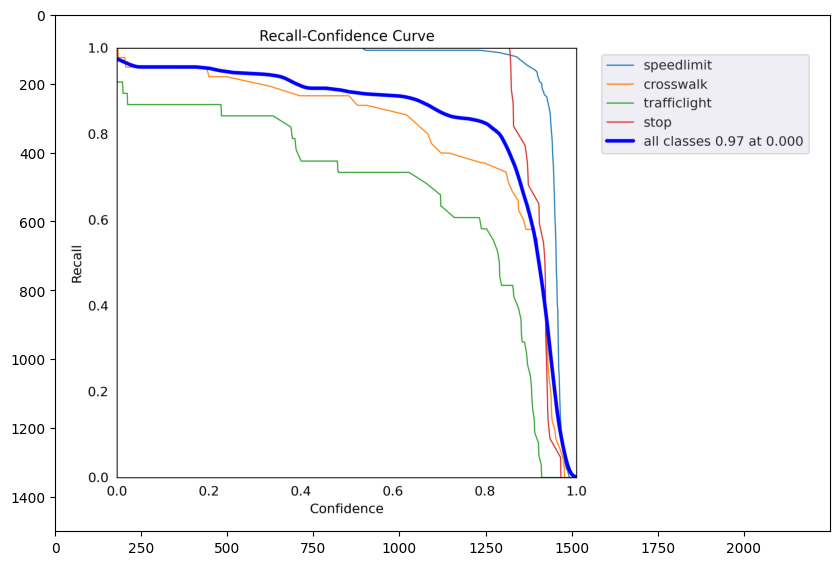

In [32]:
img_path = exp_path + '/R_curve.png'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)

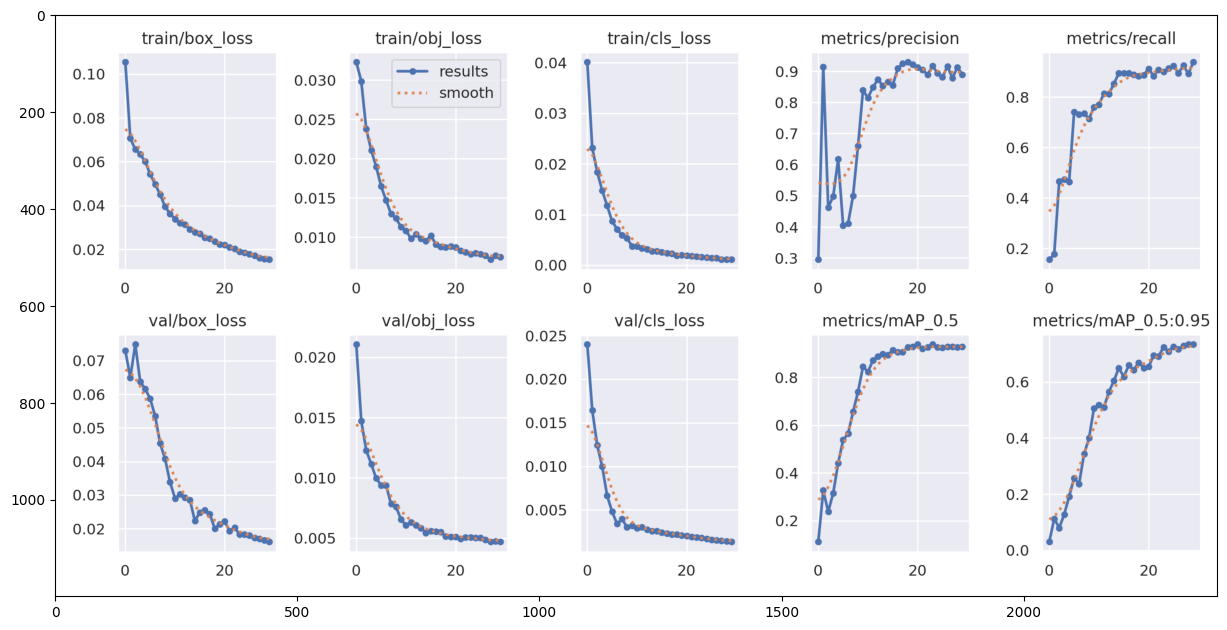

In [33]:
img_path = exp_path + '/results.png'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.imshow(img)

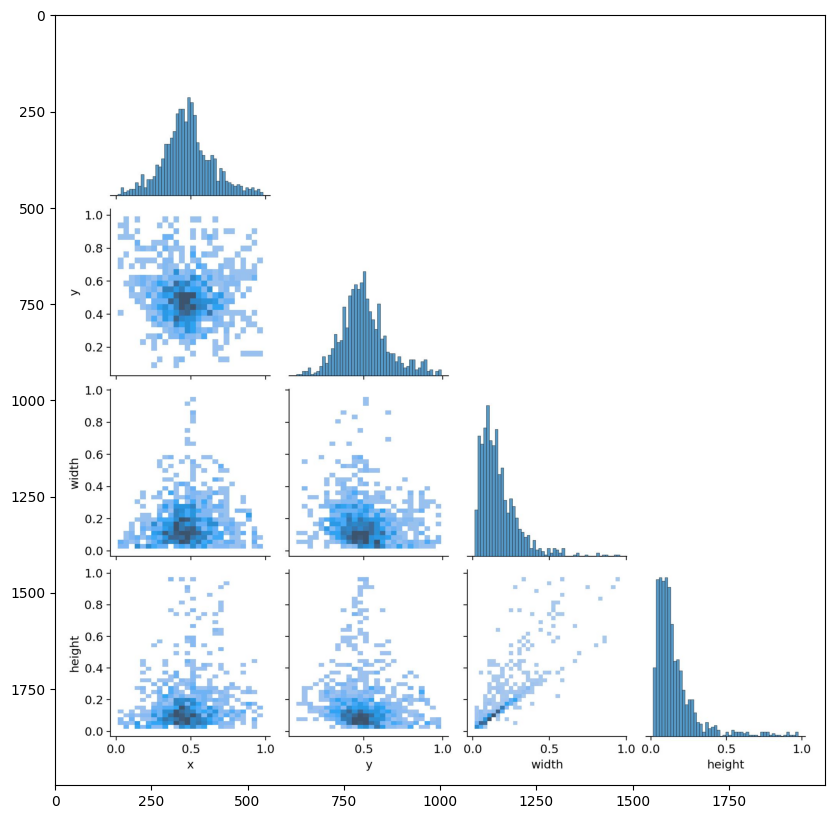

In [34]:
img_path = exp_path + '/labels_correlogram.jpg'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)

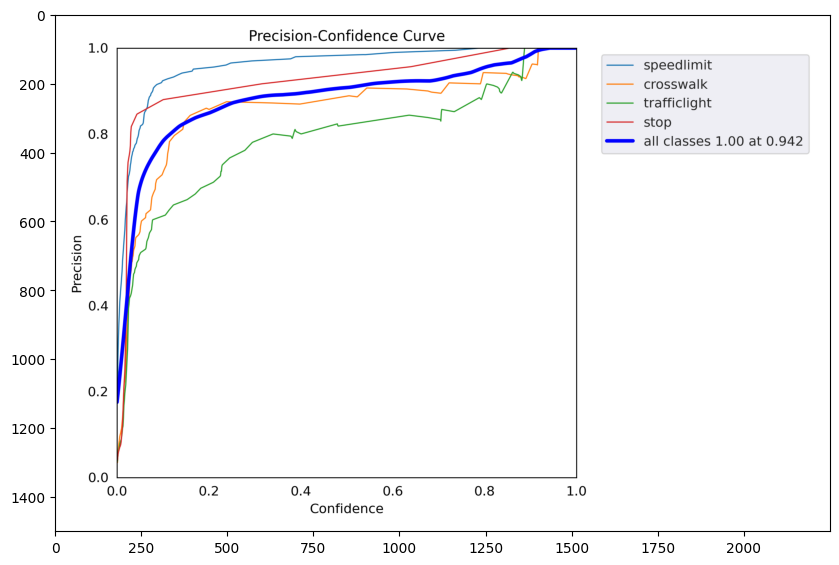

In [35]:
img_path = exp_path + '/P_curve.png'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)

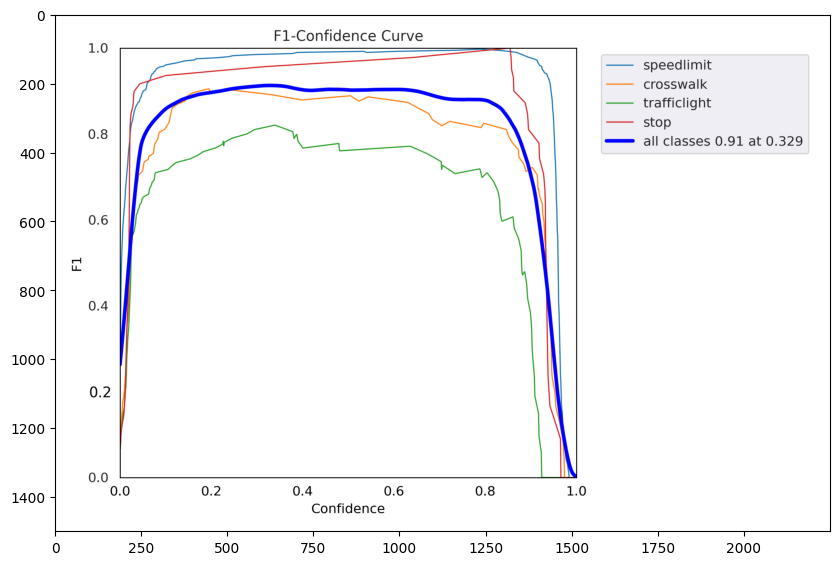

In [36]:
img_path = exp_path + '/F1_curve.png'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)

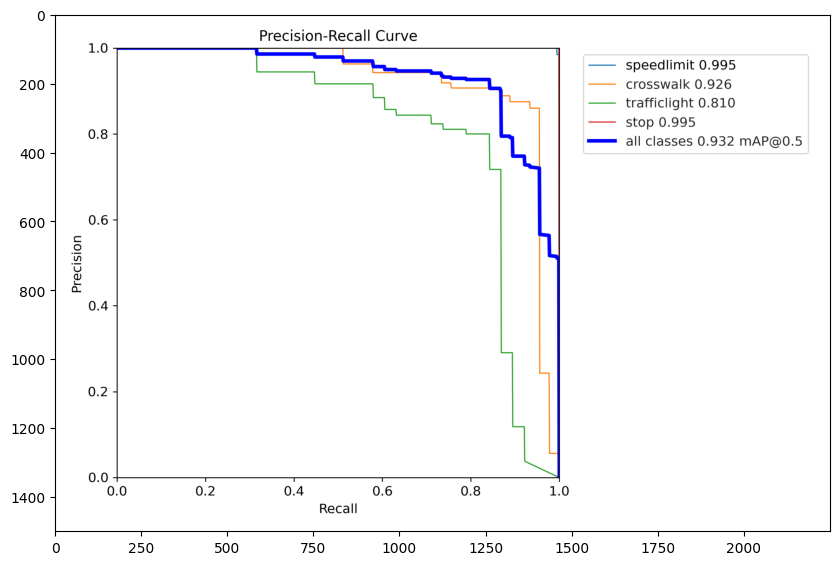

In [37]:
img_path = exp_path + '/PR_curve.png'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)